设 $\Omega=[0,1]^2$，真解 $u=[x_1(1-x_1)x_2(1-x_2),0]$。$u$ 的选择确保了在边界 $\partial\Omega$ 上 $u=0$。

$$f = 
\begin{bmatrix}
35/13x_2-35/13x_2^2+10/13x_1-10/13x_1^2\\
-25/26(-1+2x_2)(-1+2x_1)
\end{bmatrix}$$
其中 $E=1$ 和 $\nu=0.3$。

In [5]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags

import numpy as np

from fealpy.functionspace import LagrangeFESpace as Space
from fealpy.fem import LinearElasticityOperatorIntegrator
from fealpy.fem import BilinearForm
from fealpy.fem import VectorSourceIntegrator
from fealpy.fem import LinearForm

from linear_elasticity_model3d import BoxDomainData3d

pde = BoxDomainData3d()
mu = pde.mu
lambda_ = pde.lam
domain = pde.domain()
mesh = pde.init_mesh(n=1)

In [6]:
p = 2
GD = 3
doforder = 'vdims'

maxit = 3
errorType = ['$|| uh - u ||_{L_2}$',
             '$|| uh - u ||_{L_\infty}$']
errorMatrix = np.zeros((2, maxit), dtype=np.float64)
NDof = np.zeros(maxit, dtype=np.int_)

for i in range(maxit):
    space = Space(mesh, p=p, doforder=doforder)
    uh = space.function(dim=GD)
    print("uh:", uh.shape)
    vspace = GD*(space, )
    gdof = vspace[0].number_of_global_dofs()
    vgdof = gdof * GD
    print("vgdof:", vgdof)
    ldof = vspace[0].number_of_local_dofs()
    vldof = ldof * GD
    NDof[i] = vspace[0].number_of_global_dofs()

    integrator1 = LinearElasticityOperatorIntegrator(
                lam=lambda_, mu=mu, q=p+5
                                                    )
    bform = BilinearForm(vspace)
    bform.add_domain_integrator(integrator1)
    KK = integrator1.assembly_cell_matrix(space=vspace)
    K = bform.assembly()

    integrator3 = VectorSourceIntegrator(f=pde.source, q=p+5)
    lform = LinearForm(vspace)
    lform.add_domain_integrator(integrator3)
    FK = integrator3.assembly_cell_vector(space = vspace)
    F = lform.assembly()

    dflag = vspace[0].boundary_interpolate(
        gD=pde.dirichlet, uh=uh,
        threshold=pde.is_dirichlet_boundary)
    ipoints = vspace[0].interpolation_points()
    uh[dflag] = pde.dirichlet(ipoints[dflag])
    
    F -= K@uh.flat
    F[dflag.flat] = uh.ravel()[dflag.flat]

    bdIdx = np.zeros(K.shape[0], dtype=np.int_)
    bdIdx[dflag.flat] = 1
    D0 = spdiags(1-bdIdx, 0, K.shape[0], K.shape[0])
    D1 = spdiags(bdIdx, 0, K.shape[0], K.shape[0])
    K = D0@K@D0 + D1

    uh.flat[:] = spsolve(K, F)
    u_exact = space.interpolate(pde.solution)

    errorMatrix[0, i] = mesh.error(u=uh, v=u_exact, q=p+5, power=2)
    errorMatrix[1, i] = np.max(np.abs(uh - u_exact))
    
    if i < maxit-1:
        mesh.uniform_refine()

print("errorMatrix:\n", errorMatrix)
print("ratio:\n", errorMatrix[:, 0:-1]/errorMatrix[:, 1:])

uh: (729, 3)
vgdof: 2187
uh: (4913, 3)
vgdof: 14739
uh: (35937, 3)
vgdof: 107811
errorMatrix:
 [[0.01100266 0.01110312 0.0111144 ]
 [0.015625   0.01611565 0.01612218]]
ratio:
 [[0.99095228 0.99898508]
 [0.96955449 0.99959502]]


/home/heliang/FEALPy_Development/fealpy/fealpy/tools/show.py:101: RankWarning: Polyfit may be poorly conditioned
  c = np.polyfit(np.log(N[k:]), np.log(error[k:]), 1)
/home/heliang/FEALPy_Development/fealpy/fealpy/tools/show.py:101: RankWarning: Polyfit may be poorly conditioned
  c = np.polyfit(np.log(N[k:]), np.log(error[k:]), 1)


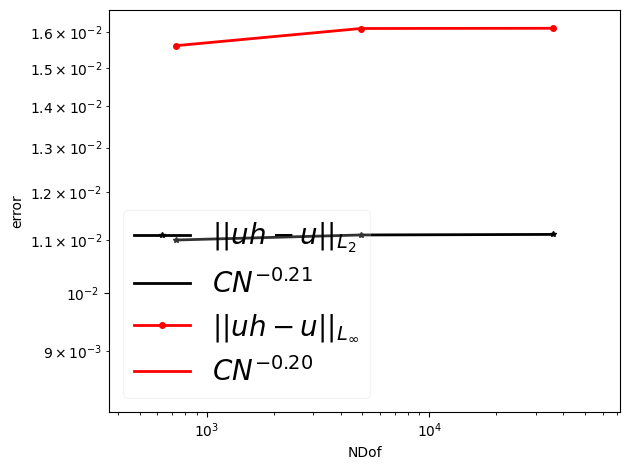

In [7]:
from fealpy.tools.show import showmultirate
import matplotlib.pyplot as plt

showmultirate(plt, 2, NDof, errorMatrix, errorType, propsize=20, lw=2, ms=4)
plt.xlabel('NDof')
plt.ylabel('error')
plt.tight_layout()
plt.show()

/home/heliang/FEALPy_Development/fealpy/fealpy/tools/show.py:101: RankWarning: Polyfit may be poorly conditioned
  c = np.polyfit(np.log(N[k:]), np.log(error[k:]), 1)
/home/heliang/FEALPy_Development/fealpy/fealpy/tools/show.py:101: RankWarning: Polyfit may be poorly conditioned
  c = np.polyfit(np.log(N[k:]), np.log(error[k:]), 1)


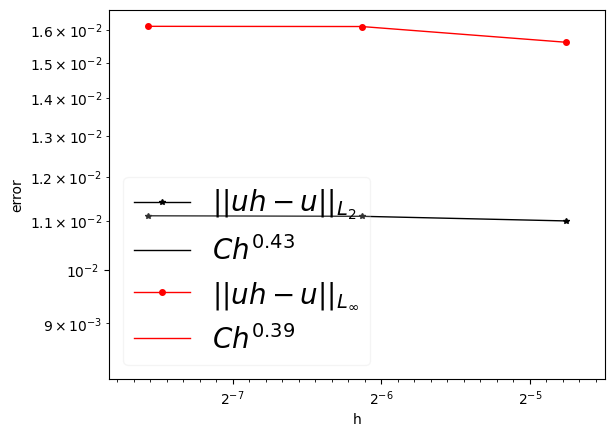

In [8]:
h = 1 / (np.power(NDof, 1/2))     
showmultirate(plt, 2, h, errorMatrix,  errorType, propsize=20)
plt.xlabel('h')
plt.ylabel('error')
plt.show()